### Imports

In [1]:
# pip install hypernetx

import hypernetx as hnx
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import networkx as nx
import os
import warnings 
warnings.filterwarnings("ignore")

### Directory Setup

In [2]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'Data')
commercial_data = os.path.join(data_dir, '236220_2018_04_01,2018_05_01.csv')

### Reading Polars and Column Removal

In [3]:
import polars as pl

# Read the CSV file
data = pl.read_csv(
    commercial_data,
    dtypes={
        "Contracting Agency ID": pl.Utf8,
        "Entity ZIP Code": pl.Utf8,
        "Modification Number": pl.Utf8
    },
    columns=[
        'Contract ID',
        'Reference IDV',
        'Award/IDV Type',
        'Action Obligation ($)',
        'Date Signed',
        'Contracting Agency ID',
        'PSC',
        'NAICS',
        'Entity State',
        'Unique Entity ID',
        'Ultimate Parent Unique Entity ID'
    ]
)

data = data.with_columns(
    pl.col("Action Obligation ($)")
    .str.replace(r"\$", "")
    .str.replace(r",", "")
    .str.replace(r",", "")
    .cast(pl.Float64)
)

data = data.rename({"Action Obligation ($)": "Prime Action Obligation"})

print(data.head())

shape: (5, 11)
┌───────────────┬───────────┬───────────────┬───────────────┬───┬────────┬──────────────┬───────────────┬──────────────┐
│ Contract ID   ┆ Reference ┆ Award/IDV     ┆ Prime Action  ┆ … ┆ NAICS  ┆ Entity State ┆ Unique Entity ┆ Ultimate     │
│ ---           ┆ IDV       ┆ Type          ┆ Obligation    ┆   ┆ ---    ┆ ---          ┆ ID            ┆ Parent       │
│ str           ┆ ---       ┆ ---           ┆ ---           ┆   ┆ i64    ┆ str          ┆ ---           ┆ Unique       │
│               ┆ str       ┆ str           ┆ f64           ┆   ┆        ┆              ┆ str           ┆ Entity …     │
│               ┆           ┆               ┆               ┆   ┆        ┆              ┆               ┆ ---          │
│               ┆           ┆               ┆               ┆   ┆        ┆              ┆               ┆ str          │
╞═══════════════╪═══════════╪═══════════════╪═══════════════╪═══╪════════╪══════════════╪═══════════════╪══════════════╡
│ 12034318C0020 ┆

### Additional Processing - Concatenating Deobligations

### Dataframe Analysis

In [15]:
print(data['Contract ID'].unique())
print(len(data))
value_counts = data['Contract ID'].value_counts()
unique_contract_ids = value_counts.filter(pl.col("count") == 1)['Contract ID']
filtered_data = data.filter(pl.col("Contract ID").is_in(unique_contract_ids))
print(filtered_data)

shape: (913,)
Series: 'Contract ID' [str]
[
	"W9123817C0030"
	"W9128F14C0068"
	"GS07P16UTC7012"
	"W9124717C0029"
	"N4008017C0014"
	…
	"DTFACT17C00002"
	"W564KV13C4023"
	"33330218CF0010209"
	"N6247316C4602"
	"VA24413C0347"
]
1219
shape: (771, 11)
┌───────────────┬───────────┬───────────────┬───────────────┬───┬────────┬──────────────┬───────────────┬──────────────┐
│ Contract ID   ┆ Reference ┆ Award/IDV     ┆ Prime Action  ┆ … ┆ NAICS  ┆ Entity State ┆ Unique Entity ┆ Ultimate     │
│ ---           ┆ IDV       ┆ Type          ┆ Obligation    ┆   ┆ ---    ┆ ---          ┆ ID            ┆ Parent       │
│ str           ┆ ---       ┆ ---           ┆ ---           ┆   ┆ i64    ┆ str          ┆ ---           ┆ Unique       │
│               ┆ str       ┆ str           ┆ f64           ┆   ┆        ┆              ┆ str           ┆ Entity …     │
│               ┆           ┆               ┆               ┆   ┆        ┆              ┆               ┆ ---          │
│               ┆           

### Data Visualization with subset

In [57]:
data.columns

# 'Contract ID', = 0
#  'Reference IDV', = 1
#  'Award/IDV Type', = 2
#  'Prime Action Obligation', = 3
#  'Date Signed', = 4
#  'Contracting Agency ID', = 5
#  'PSC', = 6
#  'NAICS', = 7
#  'Entity State', = 8
#  'Unique Entity ID', = 9
#  'Ultimate Parent Unique Entity ID' = 10

['Contract ID',
 'Reference IDV',
 'Award/IDV Type',
 'Prime Action Obligation',
 'Date Signed',
 'Contracting Agency ID',
 'PSC',
 'NAICS',
 'Entity State',
 'Unique Entity ID',
 'Ultimate Parent Unique Entity ID']

C:\Users\doran\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
C:\Users\doran\anaconda3\lib\site-packages\hypernetx\classes\hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])


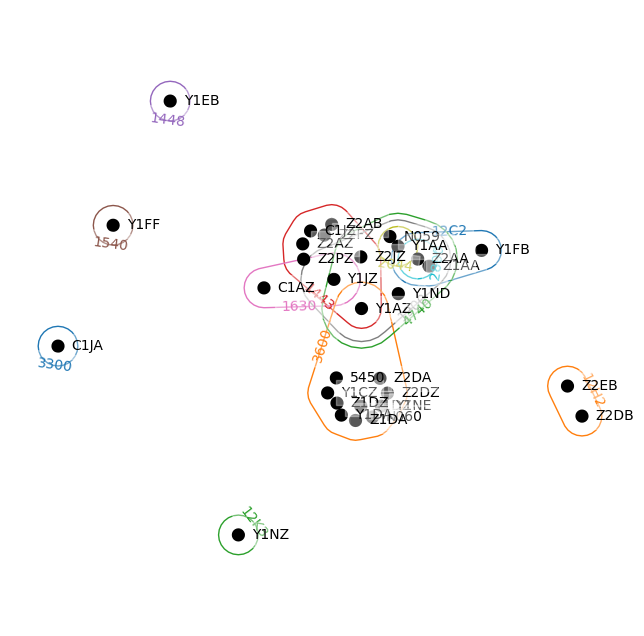

In [61]:
filtered_subset = filtered_data[:100]
# filtered_subset.columns
graph_dict = {}

for row in filtered_subset.rows():
    hyperedge = row[5]
    vertex = row[6]
    if row[5] in graph_dict:
        graph_dict[hyperedge].append(vertex)
    else:
        graph_dict[hyperedge] = [vertex]

H = hnx.Hypergraph(graph_dict)
hnx.drawing.draw(H)
